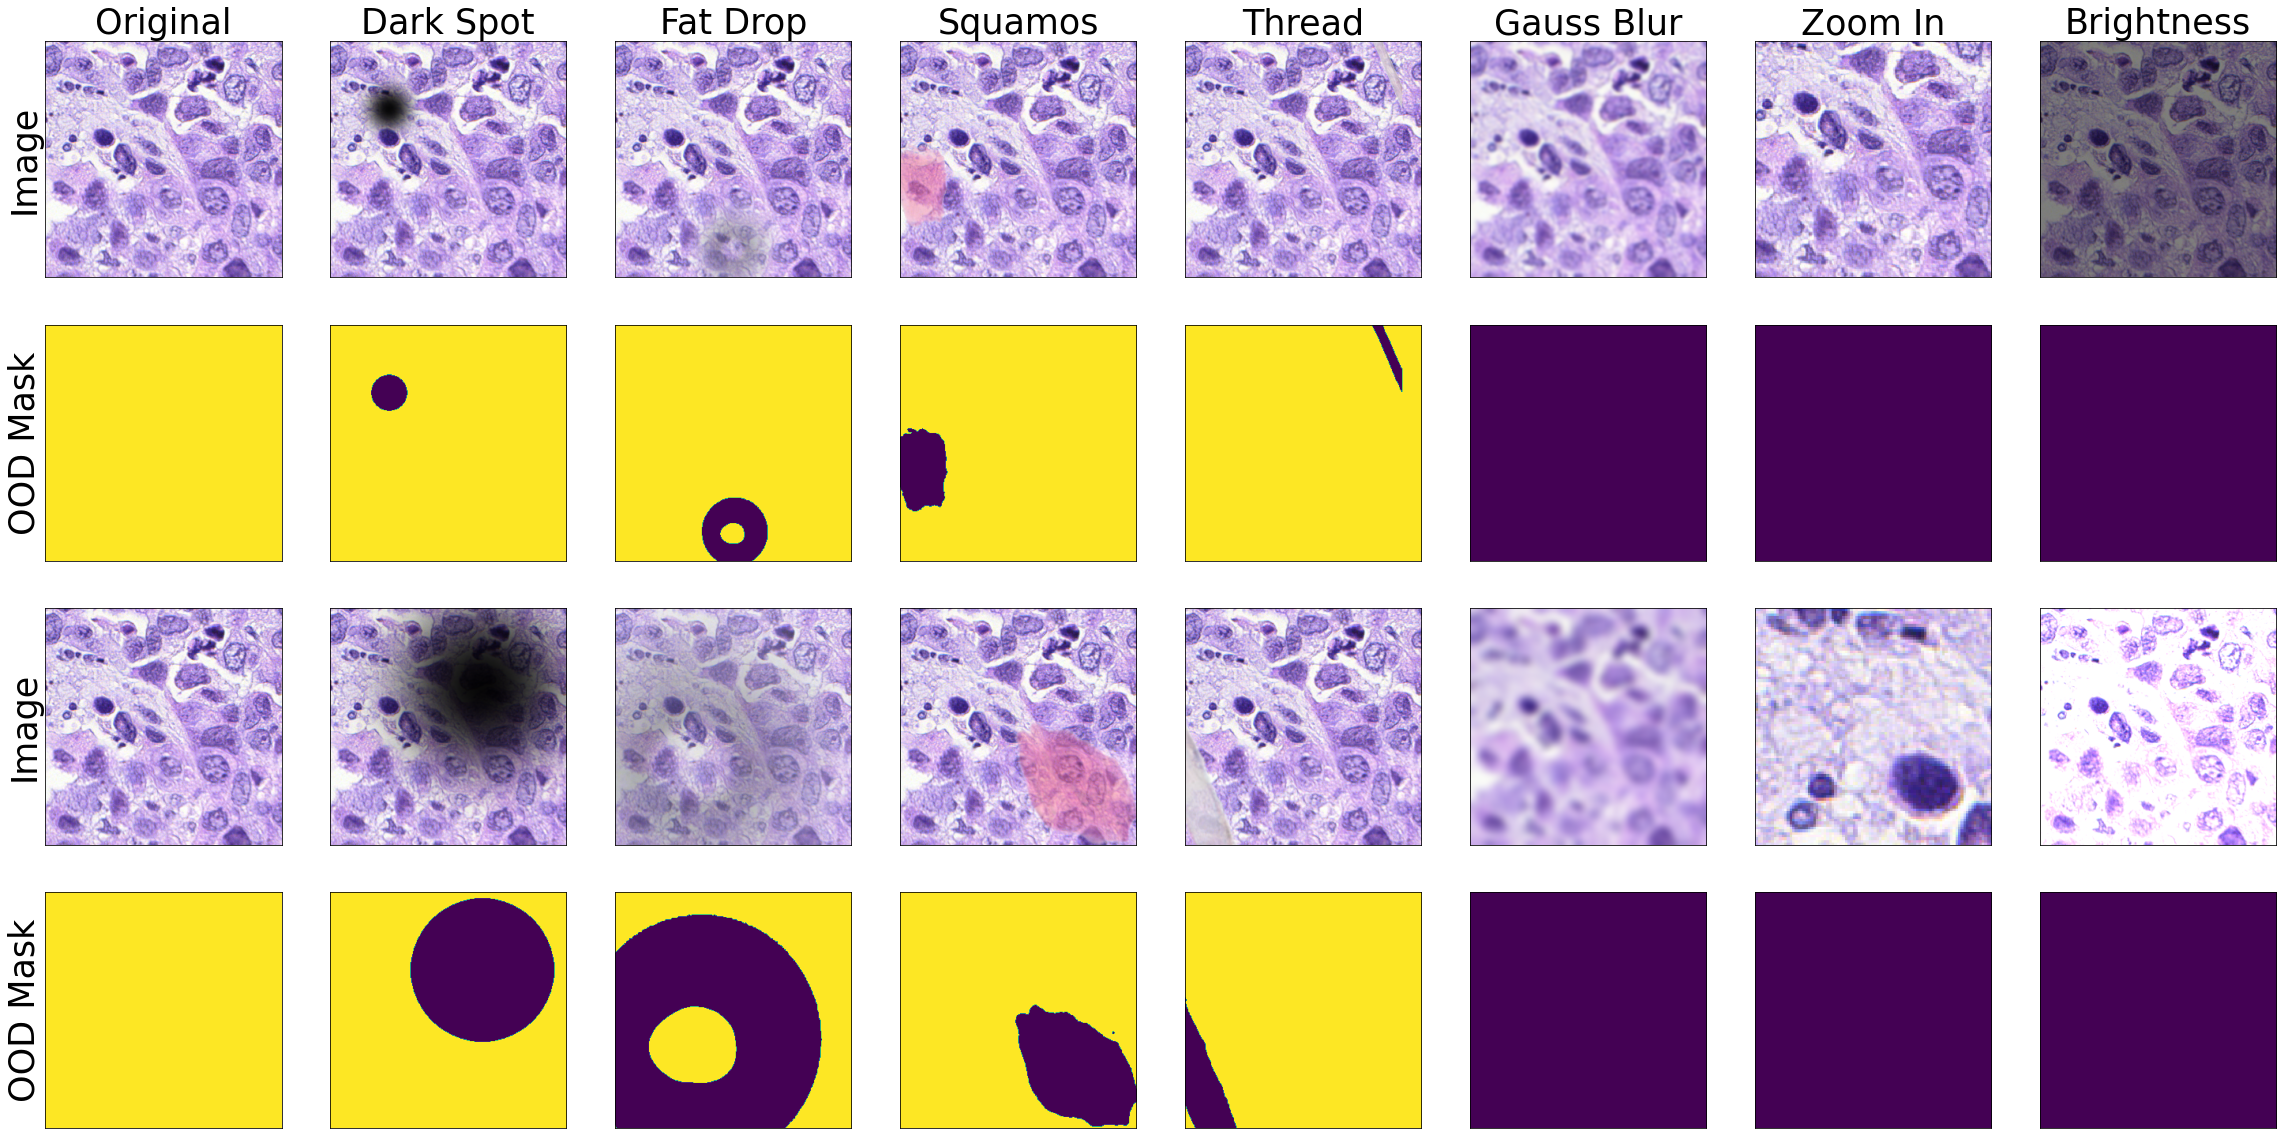

In [1]:
from froodo.quickstart import *
import matplotlib.pyplot as plt
from copy import deepcopy

augmentations = [
    [Nothing(), Nothing()],
    [DarkSpotsAugmentation(0.5), DarkSpotsAugmentation(2)],
    [FatAugmentation(0.55), FatAugmentation(2)],
    [SquamousAugmentation(0.5), SquamousAugmentation(2)],
    [ThreadAugmentation(0.5), ThreadAugmentation(2)],
    [GaussianBlurAugmentation(sigma=1.8), GaussianBlurAugmentation(sigma=5)],
    [ZoomInAugmentation(0.8), ZoomInAugmentation(0.3)],
    [BrightnessAugmentation(0.5), BrightnessAugmentation(1.5)]
]

titles = ["Original", "Dark Spot", "Fat Drop", "Squamos", "Thread", "Gauss Blur", "Zoom In", "Brightness"]

dataset = BCSS_Adapted_Cropped_Resized_Datasets().test
sample = dataset[900]

f, ax = plt.subplots(4, len(augmentations), figsize=(5 * len(augmentations), 20))

ax[0,0].set_ylabel("Image", fontsize=35)
ax[1,0].set_ylabel("OOD Mask", fontsize=35)
ax[2,0].set_ylabel("Image", fontsize=35)
ax[3,0].set_ylabel("OOD Mask", fontsize=35)

for i in range(len(augmentations)):
    for j in range(len(augmentations[i])):
        if j == 0:
            ax[0,i].set_title(titles[i], fontsize=35)
        s = deepcopy(sample)
        s = augmentations[i][j](s)
        ax[2*j, i].imshow(s.image.permute(1,2,0))
        ax[2*j+1, i].imshow(s["ood_mask"], vmin=0, vmax=1)
        ax[2*j, i].set_yticks([])
        ax[2*j, i].set_xticks([])
        ax[2*j+1, i].set_yticks([])
        ax[2*j+1, i].set_xticks([])
plt.show()

# Segmentation example for Augmentation Strategy

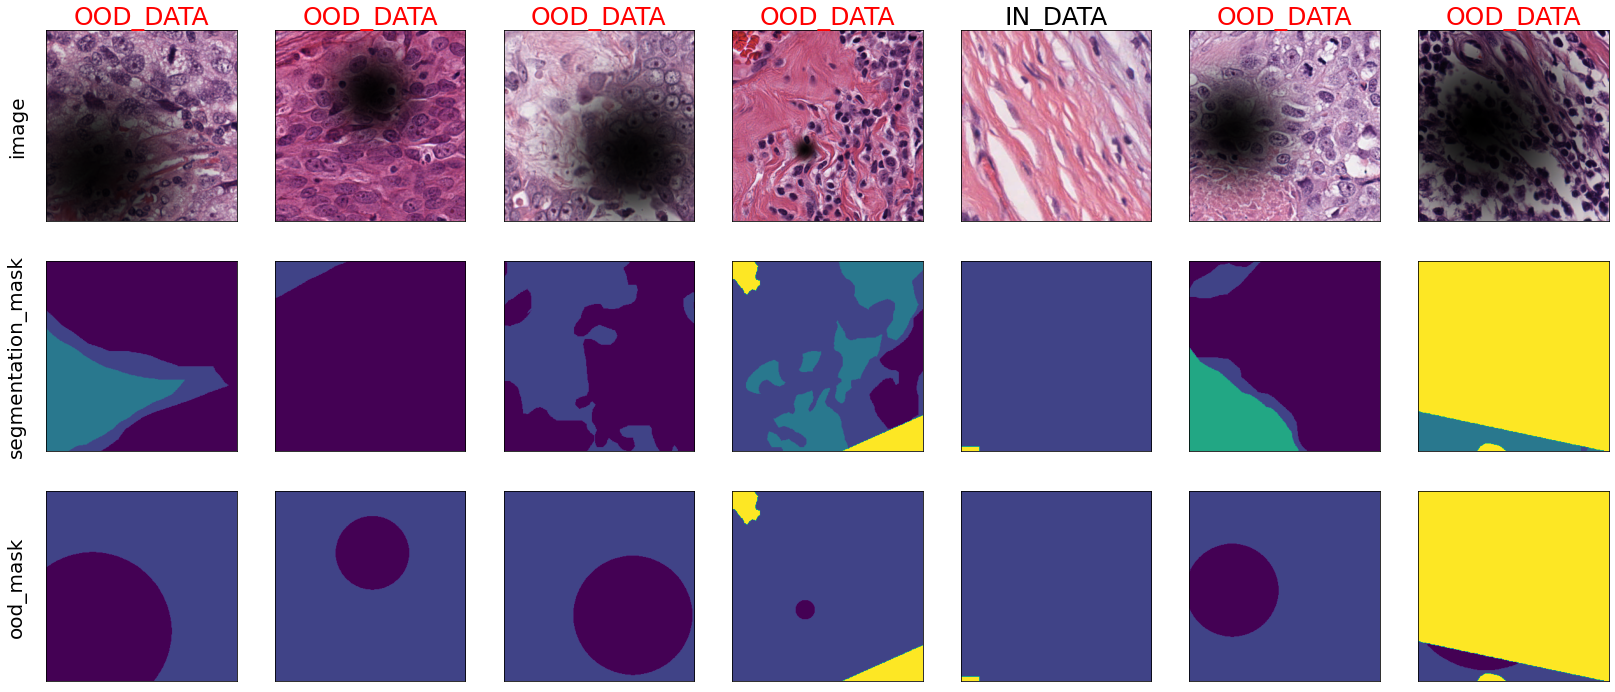

OOD Evaluation:   0%|          | 0/179 [00:00<?, ?it/s]c:\Users\jstieber\AppData\Local\conda\conda\envs\ssl4uc\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
OOD Evaluation: 100%|██████████| 179/179 [01:38<00:00,  1.83it/s]


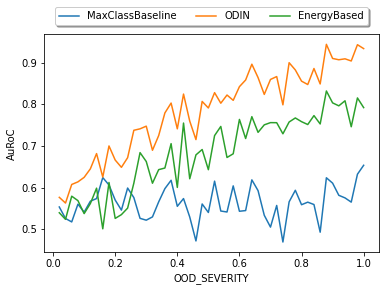

Name                                                   AUC
------------------------------------------------  --------
MaxClassBaseline no params                        0.564756
ODIN temp: 2, noise: 0.004 temp: 2, noise: 0.004  0.739577
EnergyBased temp: 1                               0.648461


In [2]:
from froodo import *


# init network
net = SegmentationModel().load()

# create dataset adapter
adapter = GeneralDatasetAdapter(BCSS_Adapted_Cropped_Resized_Datasets().test)

# choose metrics
metrics = [
    OODAuRoC(bin_by='OOD_SEVERITY', num_bins=50),
    OODAuRoC(),
]

# choose post-hoc OOD methods
methods = [MaxClassBaseline(), ODIN(), EnergyBased()]

# create experiment component
experiment = AugmentationOODEvaluationComponent(
    data_adapter=adapter,
    augmentation=SampledAugmentation(DarkSpotsAugmentation()),
    model=net,
    metrics=metrics,
    methods=methods,
    seed=4321,
    task_type=TaskType.SEGMENTATION
)

# run experiment
experiment()

# Classification Example for Augmentation Strategy

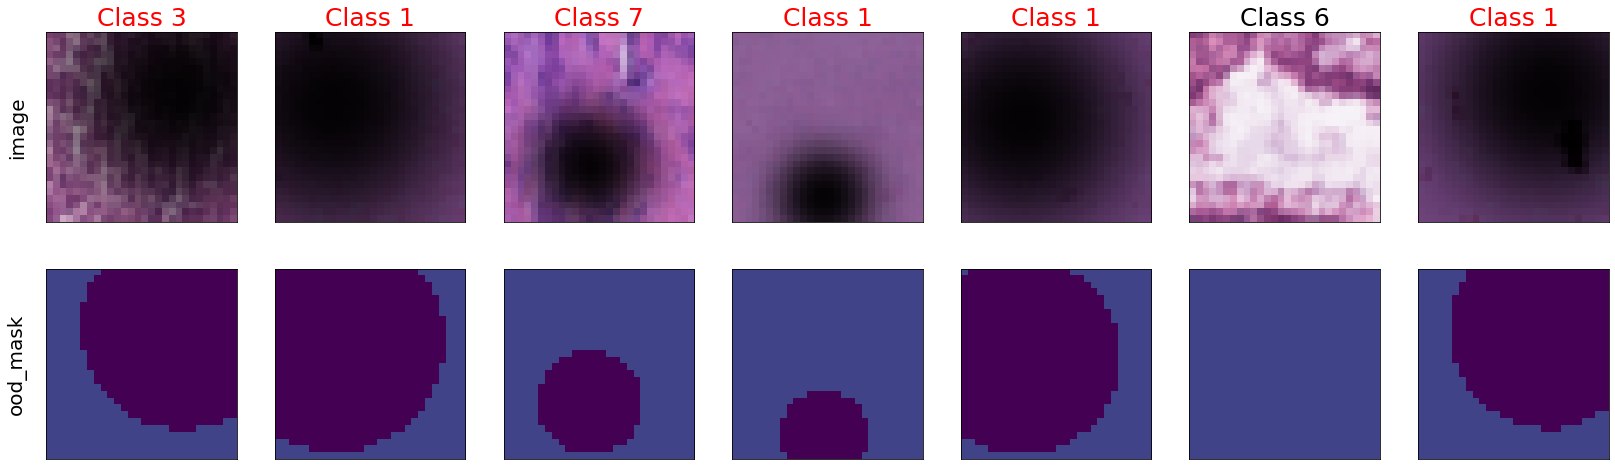

OOD Evaluation: 100%|██████████| 57/57 [00:44<00:00,  1.28it/s]


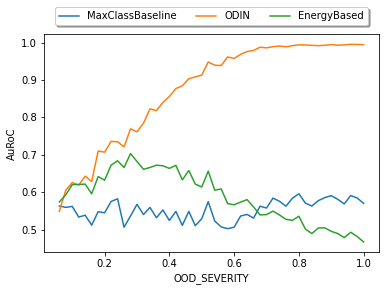

Name                                                   AUC
------------------------------------------------  --------
MaxClassBaseline no params                        0.553331
ODIN temp: 2, noise: 0.004 temp: 2, noise: 0.004  0.873223
EnergyBased temp: 1                               0.583515


In [5]:
from froodo import *


# init network
net = ResNet50(3, 9)
net.load_state_dict(
    # load in your weights
)
net = net.cuda()

# create dataset adapter
dataset = PathMNIST_Adapted()

# choose metrics
metrics = [
    OODAuRoC(bin_by='OOD_SEVERITY', num_bins=50),
    OODAuRoC(),
]

# choose post-hoc OOD methods
methods = [MaxClassBaseline(), ODIN(), EnergyBased()]

# create experiment component
experiment = AugmentationOODEvaluationComponent(
    data_adapter=dataset,
    augmentation=SampledAugmentation(DarkSpotsAugmentation(sample_intervals=[(0.1,0.45)])),
    model=net,
    metrics=metrics,
    methods=methods,
    seed=4321,
    task_type=TaskType.CLASSIFICATION,
    batch_size=128,
    num_workers=0
)

# run experiment
experiment()

# Classification Example for Dataset Strategy

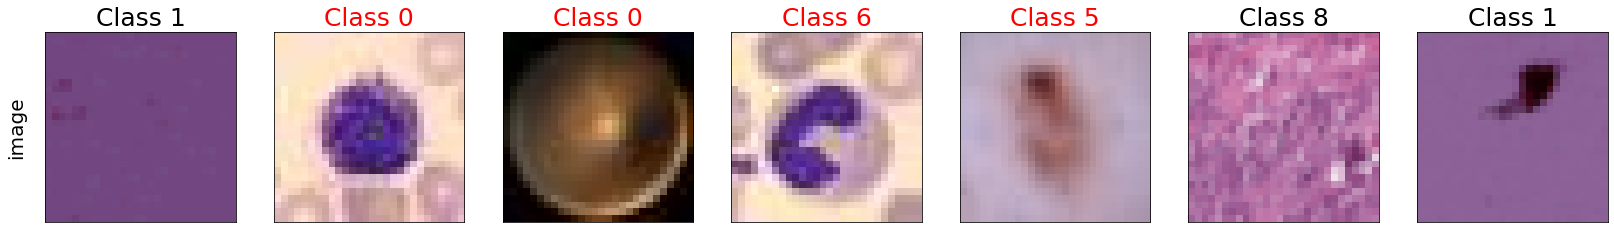

OOD Evaluation: 100%|██████████| 102/102 [00:40<00:00,  2.50it/s]


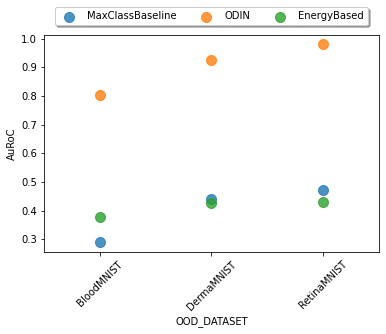

Name                                                   AUC
------------------------------------------------  --------
MaxClassBaseline no params                        0.354114
ODIN temp: 2, noise: 0.004 temp: 2, noise: 0.004  0.857204
EnergyBased temp: 1                               0.39721


In [4]:
from froodo import *

# init network
net = ResNet50(3, 9)
net.load_state_dict(
    # load in your weights
)
net = net.cuda()

metrics = [
    OODAuRoC(group_by="OOD_DATASET"),
    OODAuRoC(),
]

# choose post-hoc OOD methods
methods = [
    MaxClassBaseline(),
    ODIN({"noise": 0.004}),
    EnergyBased(),
]

experiment = DatasetOODEvaluationComponent(
    in_dataset_list=[PathMNIST_Adapted()],
    ood_dataset_list=[
        DermaMNIST_Adapted(),
        RetinaMNIST_Adapted(),
        BloodMNIST_Adapted(),
    ],
    model=net,
    metrics=metrics,
    methods=methods,
    seed=4321,
    task_type=TaskType.CLASSIFICATION,
    batch_size=128,
    num_workers=0,
    shuffle=True,
)

# run experiment
experiment()